<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="right">
</p>

# ***CNC 머신 시계열 데이터 AI 실습***

**제목:** CNC 머신 품질 예측을 위한 AI 실습  <br>
**Description:** CNC 머신으로부터 수집한 데이터를 전처리하고, 딥러닝 모델을 사용하여 품질 예측을 수행합니다.

본 자료는 정부에서 운영하는 아래의 KAMP(한국인공지능제조플랫폼)의 데이터 및 예제를 수정한 교육자료입니다.

중소벤처기업부, Korea AI Manufacturing Platform(KAMP), CNC 머신 AI 데이터셋, KAIST(울산과학기술원, ㈜이피엠솔루션즈), 2020.12.14., www.kamp-ai.kr

https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=CNC+%EB%A8%B8%EC%8B%A0&page=1&DATASET_SEQ=3&EQUIP_SEL=&GUBUN_SEL=&FILE_TYPE_SEL=&WDATE_SEL=

※ 분석하기에 앞서 다음과 같은 가상환경이 구축되어있는지 확인해주세요. <br>
Python 버전 : 3.10.12

In [1]:
!python --version

Python 3.10.12


## 1. 분석 개요

### 1.1 분석 배경

**공정(설비) 개요:**
- CNC(Computerized Numerical Control) 가공은 컴퓨터 프로그램을 이용하여 기계의 움직임을 제어하는 정밀 가공 공정입니다.
- 주로 금속, 플라스틱, 목재 등 다양한 재료를 가공하는 데 사용되며, 복잡한 형상의 부품을 높은 정밀도로 제작할 수 있습니다.
- 일반적인 CNC 기계에는 선반, 밀링 머신, 드릴링 머신 등이 포함됩니다.

![image](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/2d412df5-461d-489d-8c2d-5779dd62ad2d)<br>
<center>[용해공정 설비(사진)]</center> <br>

**이슈사항(Pain Point):**
- CNC 절삭공구는 마찰과 절삭력 변화로 마모되거나 파손되어 가공 정밀도가 떨어질 수 있습니다.
- 공정 중 다양한 변수로 인해 품질이 변동되며, 제품 성형 후에야 불량 여부를 확인할 수 있어 일관된 품질 관리가 어렵습니다.

### 1.2 분석 목표

**분석 목표:**
- CNC 설비와 네트워크 연결을 통해 실제 가공생산데이터를 수집하여 공구수명에 따른 가공불량 예측을 딥러닝 알고리즘을 활용하여 해결하고자합니다.

**제조 데이터 분석 기대효과:**
- 데이터 분석을 통해 설비 운영 조건에 따른 생산 품질을 예측하고, 불량률을 낮추기 위한 최적의 운영 조건을 도출합니다.

### 1.3 제조데이터 소개

**데이터 수집 방법:**
- 제조 분야 : 자동차 부품
- 제조 공정명 : 자동차 부품 CNC 가공 공정
- 수집 장비 : 공장 내 CNC 가공 장비 Data, 조건 및 품질 Data 
- 수집 기간 : 5일
- 수집 주기 : 1 sec

**데이터 유형/구조:**<br>
 - 데이터 크기, 데이터 수량: 48개 컬럼, 32,048개의 관측치
 - 데이터 속성 정의 표:<br>
![CNC_1](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/bb3f6ed9-1943-4895-b5a3-83e26187d1c0)<br>
 - 독립변수/종속변수 정의:<br>
 ![CNC_3](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/b9cd02c8-ddf0-426a-8031-4bed3a8a45f6)<br>
 ![CNC_4](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/97af43da-4c2a-49e8-9e99-baf32566a017)

## 2. 분석 실습


### 2-1. 라이브러리 / 데이터 불러오기

#### 필요한 라이브러리 설치 및 불러오기

In [2]:
!pip install --upgrade pip

In [3]:
!pip install tensorflow==2.16.1 pandas==2.2.2 numpy==1.26.4 matplotlib==3.9.0 scikit-learn==1.5.0 imbalanced-learn==0.9.0

In [106]:
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import tensorflow as tf
import random

In [107]:
# 시드 고정
def set_seed(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    random.seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "1"
    os.environ['TF_CUDNN_DETERMINISM'] = "1"
    os.environ['PYTHONHASHSEED'] = str(seed)
set_seed()

#### 데이터 불러오기

In [108]:
# CNC 가공 실적 데이터 파일
train_sample = pd.read_csv("./dataset/CNC 비식별화 원본데이터_1209/train.csv", header=0, encoding='utf-8')

# 개별 생산 단위 데이터 파일
path = r'./dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2'  # 경로 설정
all_files = glob.glob(os.path.join(path, "*.csv"))

li_df = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    li_df.append(df)

df = pd.concat(li_df, axis=0, ignore_index=True)

### 2-2. 데이터 특성 파악


#### 데이터 기본 구조 파악

In [109]:
train_sample.head()

,No,material,feedrate,clamp_pressure,tool_condition,machining_finalized,passed_visual_inspection
0,1,aluminum,6,4.0,unworn,yes,yes
1,2,aluminum,20,4.0,unworn,yes,yes
2,3,aluminum,6,3.0,unworn,yes,yes
3,4,aluminum,6,2.5,unworn,no,NaN
4,5,aluminum,20,3.0,unworn,no,NaN


In [110]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        25 non-null     int64  
 1   material                  25 non-null     object 
 2   feedrate                  25 non-null     int64  
 3   clamp_pressure            25 non-null     float64
 4   tool_condition            25 non-null     object 
 5   machining_finalized       25 non-null     object 
 6   passed_visual_inspection  19 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ KB


In [111]:
all_files

['./dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_01.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_02.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_03.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_04.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_05.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_06.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_07.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_08.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_09.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_10.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_11.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experiment_12.csv',
 './dataset/CNC 비식별화 원본데이터_1209/CNC Virtual Data set _v2\\experi

In [112]:
df.head()

,X_ActualPosition,X_ActualVelocity,X_ActualAcceleration,X_SetPosition,X_SetVelocity,X_SetAcceleration,X_CurrentFeedback,X_DCBusVoltage,X_OutputCurrent,X_OutputVoltage,...,S_CurrentFeedback,S_DCBusVoltage,S_OutputCurrent,S_OutputVoltage,S_OutputPower,S_SystemInertia,M_CURRENT_PROGRAM_NUMBER,M_sequence_number,M_CURRENT_FEEDRATE,Machining_Process
0,202.0,4.0,4.00,202.0,4.0,4.000000,0.18,0.0207,329,2.77,...,0.524,2.740000e-19,329,0.0,6.960000e-07,16.0,1,0,50,Starting
1,202.0,-6.8,-346.00,202.0,-9.6,-354.000000,-10.90,0.1860,328,23.30,...,-0.288,2.740000e-19,328,0.0,-5.270000e-07,16.0,1,4,50,Prep
2,200.0,-13.8,-2.25,200.0,-13.9,3.999905,-8.59,0.1400,328,30.60,...,0.524,2.740000e-19,328,0.0,9.100000e-07,16.0,1,7,50,Prep
3,198.0,-14.0,4.00,198.0,-13.9,3.999905,-6.11,0.1300,327,30.30,...,-0.180,2.740000e-19,328,0.0,1.070000e-06,16.0,1,7,50,Prep
4,197.0,-13.9,-14.80,196.0,-13.9,4.000095,-5.70,0.1140,328,30.50,...,0.226,2.740000e-19,328,0.0,1.960000e-06,16.0,1,7,50,Prep


In [113]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32048 entries, 0 to 32047
Data columns (total 48 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   X_ActualPosition          32048 non-null  float64
 1   X_ActualVelocity          32048 non-null  float64
 2   X_ActualAcceleration      32048 non-null  float64
 3   X_SetPosition             32048 non-null  float64
 4   X_SetVelocity             32048 non-null  float64
 5   X_SetAcceleration         32048 non-null  float64
 6   X_CurrentFeedback         32048 non-null  float64
 7   X_DCBusVoltage            32048 non-null  float64
 8   X_OutputCurrent           32048 non-null  int64  
 9   X_OutputVoltage           32048 non-null  float64
 10  X_OutputPower             32048 non-null  float64
 11  Y_ActualPosition          32048 non-null  float64
 12  Y_ActualVelocity          32048 non-null  float64
 13  Y_ActualAcceleration      32048 non-null  float64
 14  Y_SetP

In [114]:
print(df.describe())

       X_ActualPosition  X_ActualVelocity  X_ActualAcceleration  \
count      32048.000000      32048.000000          32048.000000   
mean         163.805667          3.992182              4.455950   
std           18.461808          5.629767             91.780434   
min          144.000000        -17.300000          -1275.000000   
25%          150.000000          2.330000            -26.300000   
50%          158.000000          4.025000              4.000000   
75%          167.000000          5.175000             30.000000   
max          203.000000         55.300000           1444.000000   

       X_SetPosition  X_SetVelocity  X_SetAcceleration  X_CurrentFeedback  \
count   32048.000000   32048.000000       32048.000000       32048.000000   
mean      163.804013       3.997159           4.435959          -0.477972   
std        18.462444       5.634569          72.012521           4.230802   
min       144.000000     -17.000000        -997.000000         -23.400000   
25%       1

#### 종속변수 별 샘플 수 세기

- machining_finalized = 공정완료 유무<br>
- passed_visual_inspection = 육안검사 통과유무


In [115]:
train_sample.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   No                        25 non-null     int64  
 1   material                  25 non-null     object 
 2   feedrate                  25 non-null     int64  
 3   clamp_pressure            25 non-null     float64
 4   tool_condition            25 non-null     object 
 5   machining_finalized       25 non-null     object 
 6   passed_visual_inspection  19 non-null     object 
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ KB


In [116]:
nb_pass = 0
nb_pass_half = 0
nb_defective = 0

train_sample_np = np.array(train_sample.copy())
for i in range(len(train_sample_np)):
    if train_sample_np[i, 5] == 'yes' and train_sample_np[i, 6] == 'yes':
        nb_pass += 1
    elif train_sample_np[i, 5] == 'yes' and train_sample_np[i, 6] == 'no':
        nb_pass_half += 1
    else:
        nb_defective += 1

print(f'공정 완료 및 육안검사 통과: {nb_pass}')
print(f'공정 완료되었으나 육안검사 불합격: {nb_pass_half}')
print(f'공정 미완료: {nb_defective}')
print(f'전체 샘플 개수: {nb_pass + nb_pass_half + nb_defective}')

공정 완료 및 육안검사 통과: 13
공정 완료되었으나 육안검사 불합격: 6
공정 미완료: 6
전체 샘플 개수: 25


### 2-3. 데이터 정제(전처리)


#### CNC 가공 실적 데이터 파일 전처리
- tool_condition 함수: 입력값으로 불러온 ‘train.csv’ 파일을 받고, 출력값으로 각 샘플의 tool_condition에 대해 ‘마모되지않음(unworn)‘ 이면 (0)을, ’마모됨(worn)’ 이면 (1)
- item_inspection 함수: 입력값으로 불러온 ‘train.csv’ 파일을 받고, 출력값으로 각 샘플의 machining_finalized(공정완료)와 passed_visual_inspection(육안검사) 두
가지 항목을 확인하고, 공정완료 및 육안검사 합격(0), 공정완료 및 육안검사 불합격(1), 공정미완료(2)의 3가지 값을 갖는다.

In [117]:
def tool_condition(df):
    df['tool_condition'] = df['tool_condition'].apply(lambda x: 0 if x == 'unworn' else 1)
    return df

def item_inspection(df):
    df['passed_visual_inspection'] = df.apply(
        lambda row: 
            0 if row['machining_finalized'] == 'yes' and row['passed_visual_inspection'] == 'yes'
                else 1 if row['machining_finalized'] == 'yes' and row['passed_visual_inspection'] == 'no'
                    else 2, axis=1)
    return df


In [118]:
train_sample_info = tool_condition(train_sample.copy())
train_sample_info = item_inspection(train_sample_info)
train_sample_info = train_sample_info.drop(columns=['No', 'material', 'machining_finalized'])
train_sample_info = np.array(train_sample_info)

In [119]:
train_sample_info

array([[ 6. ,  4. ,  0. ,  0. ],
       [20. ,  4. ,  0. ,  0. ],
       [ 6. ,  3. ,  0. ,  0. ],
       [ 6. ,  2.5,  0. ,  2. ],
       [20. ,  3. ,  0. ,  2. ],
       [ 6. ,  4. ,  1. ,  1. ],
       [20. ,  4. ,  1. ,  2. ],
       [20. ,  4. ,  1. ,  1. ],
       [15. ,  4. ,  1. ,  1. ],
       [12. ,  4. ,  1. ,  1. ],
       [ 3. ,  4. ,  0. ,  0. ],
       [ 3. ,  3. ,  0. ,  0. ],
       [ 3. ,  4. ,  1. ,  0. ],
       [ 3. ,  3. ,  1. ,  0. ],
       [ 6. ,  3. ,  1. ,  0. ],
       [20. ,  3. ,  1. ,  2. ],
       [ 3. ,  2.5,  0. ,  0. ],
       [ 3. ,  2.5,  1. ,  0. ],
       [15. ,  4. ,  1. ,  1. ],
       [12. ,  4. ,  0. ,  2. ],
       [ 3. ,  4. ,  0. ,  1. ],
       [20. ,  3. ,  1. ,  0. ],
       [ 3. ,  4. ,  1. ,  2. ],
       [ 3. ,  3. ,  0. ,  0. ],
       [ 6. ,  2.5,  1. ,  0. ]])

#### CNC 실적 및 개별 생산 단위 데이터 통합 후 공정 및 육안 검사 상태별 분할
- data_pass : 공정 완료 및 육안검사 통과한 전체 데이터
- data_pass_half : 공정 완료되었으나 육안검사 불합격한 전체 데이터
- data_fail : 공정 미완료한 전체 데이터

In [120]:
k = 0
li_pass = []
li_pass_half = []
li_fail = []

for filename in all_files:
    file_df = pd.read_csv(filename, index_col=None, header=0)

    if train_sample_info[k, 3] == 0:
        li_pass.append(file_df)
    elif train_sample_info[k, 3] == 1:
        li_pass_half.append(file_df)
    else:
        li_fail.append(file_df)
    k+=1

data_pass = pd.concat(li_pass, axis=0, ignore_index=True)
data_pass_half = pd.concat(li_pass_half, axis=0, ignore_index=True)
data_fail = pd.concat(li_fail, axis=0, ignore_index=True)

print(f'공정 완료 및 육안검사 통과한 전체 데이터 수: {len(data_pass)}')
print(f'공정 완료되었으나 육안검사 불합격한 전체 데이터 수 : {len(data_pass_half)}')
print(f'공정 미완료한 전체 데이터 수 : {len(data_fail)}')

공정 완료 및 육안검사 통과한 전체 데이터 수: 22645
공정 완료되었으나 육안검사 불합격한 전체 데이터 수 : 6175
공정 미완료한 전체 데이터 수 : 3228


#### 통합 데이터 전처리
- machining_process 함수: 입력값으로 앞선 두 사용자 함수를 거친 통합 데이터를 받고, 기계의 공정상태(machining_process)를 숫자로 변환한다.

In [121]:
def machining_process(df):
    process_dict = {
        'Prep': 0, 'Layer 1 Up': 1, 'Layer 1 Down': 2, 'Layer 2 Up': 3,
        'Layer 2 Down': 4, 'Layer 3 Up': 5, 'Layer 3 Down': 6,
        'Repositioning': 7, 'End': 8,  'end': 8, 'Starting': 9
    }
    df['Machining_Process'] = df['Machining_Process'].map(process_dict)
    return df

In [122]:
data_pass = machining_process(data_pass)
data_pass_half = machining_process(data_pass_half)
data_fail = machining_process(data_fail)

In [123]:
data_pass['Machining_Process'].value_counts()

Machining_Process
1    3578
7    3299
3    2726
5    2715
2    2516
4    2272
6    2144
8    1740
0    1654
9       1
Name: count, dtype: int64

#### 데이터 라벨링
- 1: 양품
- 0: 불량품

In [124]:
data_pass['Label'] = 1
data_pass_half['Label'] = 0
data_fail['Label'] = 0

#### 훈련/테스트 데이터 분리

In [125]:
data_pass = np.array(data_pass)
data_pass_half = np.array(data_pass_half)
data_fail = np.array(data_fail)

In [126]:
def split_data(data):
    X = data[:, :-1]
    y = data[:, -1:]
    # First, split into train and (validation + test)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    # Then split (validation + test) into validation and test
    X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

In [127]:
X_train_pass, X_valid_pass, X_test_pass, y_train_pass, y_valid_pass, y_test_pass = split_data(data_pass)
X_train_pass_half, X_valid_pass_half, X_test_pass_half, y_train_pass_half, y_valid_pass_half, y_test_pass_half = split_data(data_pass_half)
X_train_fail, X_valid_fail, X_test_fail, y_train_fail, y_valid_fail, y_test_fail = split_data(data_fail)

In [128]:
X_train = np.concatenate((X_train_pass, X_train_pass_half, X_train_fail), axis=0)
y_train = np.concatenate((y_train_pass, y_train_pass_half, y_train_fail), axis=0)
X_valid = np.concatenate((X_valid_pass, X_valid_pass_half, X_valid_fail), axis=0)
y_valid = np.concatenate((y_valid_pass, y_valid_pass_half, y_valid_fail), axis=0)
X_test = np.concatenate((X_test_pass, X_test_pass_half, X_test_fail), axis=0)
y_test = np.concatenate((y_test_pass, y_test_pass_half, y_test_fail), axis=0)

#### 정규화

Min-max normalization는 데이터를 0과 1 사이의 값으로 scaling합니다.

1) data의 최대값(max)과 최소값(min)을 구한다.
2) 정규화할 데이터 값(x)과 앞서 구한 최대값(Xmax), 최소값(Xmin)을 다음의 식에 대입한다.<br>

<img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/c5a29097-0eb4-44a5-b379-2ea9df771095" width="400" height="400"/>

(19228, 48)

(6410, 48)

(6410, 48)

### 2-4. 모델 구축 및 훈련


**심층 신경망(DNN)**
- 심층 신경망(Deep Neural Network)은 여러 층의 노드로 구성된 신경망 구조를 쌓아 학습시키는 AI 알고리즘입니다.

    |<b>DNN의 기본구조</b> |
    | :--: |
    | ![](https://parallelr.com/uploads/2016/02/dnn_architecture.png)|
    | (출처:https://parallelr.com/2016/02/13/r-deep-neural-network-from-scratch/)|

  
- 각 노드는 입력 데이터를 받아 연산 후 결과를 출력하며, 활성화 함수(예: 시그모이드, ReLU)를 통해 비선형 변환을 수행합니다.

    |<b>활성화 함수 예: ReLU, sigmoid</b> |
    | :--: |
    | ![CNC_5](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/19863edd-d7a5-4d73-8462-cd238e520c82)|

- 학습은 경사 하강법을 통해 손실함수(loss function)를 최소화하는 방향으로 진행되며, 분류 문제에서는 주로 이진 교차 엔트로피(binary crossentropy)를 사용합니다.

    |<b>이진 교차 엔트로피(binary crossentropy)</b> |
    | :--: |
    | ![CNC_6](https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/e73cdb2d-da9f-49e9-a414-d364a87bff2c)|



### DNN 모델 구축

C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_56"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_142 (Dense)                    │ (None, 64)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_143 (Dense)                    │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

#### 모델 학습

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5515 - loss: 0.6690 - val_accuracy: 0.7066 - val_loss: 0.5546
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7014 - loss: 0.5480 - val_accuracy: 0.7370 - val_loss: 0.5302
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7342 - loss: 0.5250 - val_accuracy: 0.7348 - val_loss: 0.5162
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7434 - loss: 0.5111 - val_accuracy: 0.7488 - val_loss: 0.5017
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7520 - loss: 0.4965 - val_accuracy: 0.7566 - val_loss: 0.4870
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7604 - loss: 0.4813 - val_accuracy: 0.7557 - val_loss: 0.4718
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7613 - loss: 0.4659 - val_accuracy: 0.7607 - val_loss: 0.4571
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7650 - loss: 0.4512 - val_accuracy: 0.7704 - val_loss:

#### 손실 그래프 시각화

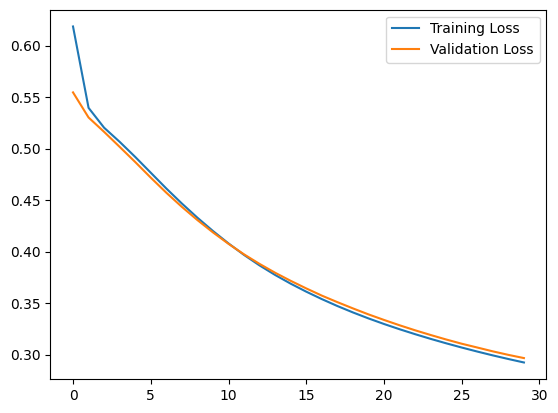

### 2-5. 모델 평가


201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

         0.0       0.78      0.74      0.76      1881
         1.0       0.89      0.91      0.90      4529

    accuracy                           0.86      6410
   macro avg       0.84      0.83      0.83      6410
weighted avg       0.86      0.86      0.86      6410

[[1391  490]
 [ 392 4137]]


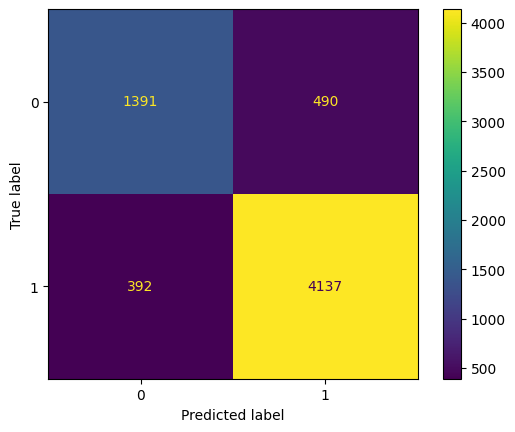

Accuracy: 0.8624
F1 Score: 0.8613


### 모델링 수정 - 레이어 구조 변경(레이어 추가)

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6601 - loss: 0.6026 - val_accuracy: 0.7462 - val_loss: 0.5079
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7610 - loss: 0.4831 - val_accuracy: 0.8086 - val_loss: 0.4143
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8087 - loss: 0.3893 - val_accuracy: 0.8381 - val_loss: 0.3471
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8469 - loss: 0.3320 - val_accuracy: 0.8520 - val_loss: 0.3083
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8668 - loss: 0.2953 - val_accuracy: 0.8749 - val_loss: 0.2740
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8824 - loss: 0.2601 - val_accuracy: 0.8963 - val_loss: 0.2408
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8999 - loss: 0.2289 - val_accuracy: 0.9080 - val_loss: 0.2248
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9139 - loss: 0.2045 - val_accuracy: 0.9139 - val_loss: 0.2018
Ep

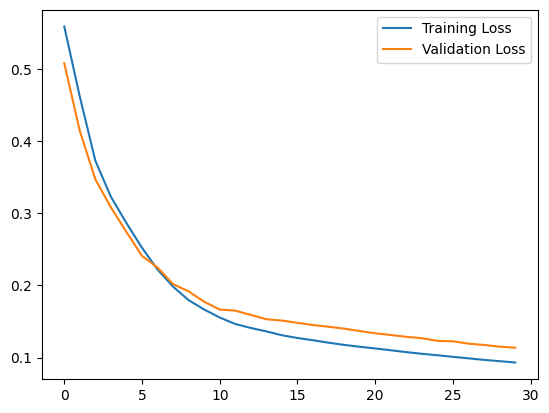

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 724us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.9557
변경 후 F1 Score: 0.9558


### 모델링 수정 - Activation 함수 변경

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7021 - loss: 0.6127 - val_accuracy: 0.7066 - val_loss: 0.5842
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7021 - loss: 0.5814 - val_accuracy: 0.7066 - val_loss: 0.5635
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7020 - loss: 0.5614 - val_accuracy: 0.6992 - val_loss: 0.5499
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7022 - loss: 0.5480 - val_accuracy: 0.7058 - val_loss: 0.5406
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7047 - loss: 0.5388 - val_accuracy: 0.7048 - val_loss: 0.5336
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7053 - loss: 0.5316 - val_accuracy: 0.7073 - val_loss: 0.5275
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7082 - loss: 0.5254 - val_accuracy: 0.7106 - val_loss: 0.5217
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7096 - loss: 0.5195 - val_accuracy: 0.7126 - val_loss: 0.5158
Epo

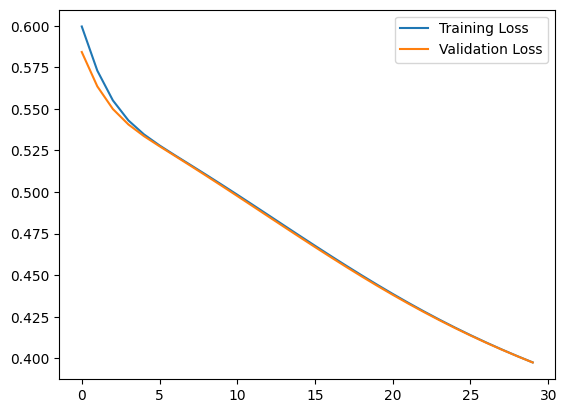

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.7994
변경 후 F1 Score: 0.7889


### 모델링 수정 - 드롭아웃 추가

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7207 - loss: 0.5877 - val_accuracy: 0.7047 - val_loss: 0.5472
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7100 - loss: 0.5423 - val_accuracy: 0.7211 - val_loss: 0.5297
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7232 - loss: 0.5254 - val_accuracy: 0.7257 - val_loss: 0.5148
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7347 - loss: 0.5104 - val_accuracy: 0.7373 - val_loss: 0.4998
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7421 - loss: 0.4955 - val_accuracy: 0.7418 - val_loss: 0.4834
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7497 - loss: 0.4802 - val_accuracy: 0.7544 - val_loss: 0.4670
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 0.4648 - val_accuracy: 0.7754 - val_loss: 0.4519
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7715 - loss: 0.4483 - val_accuracy: 0.7872 - val_loss: 0.4375
Epo

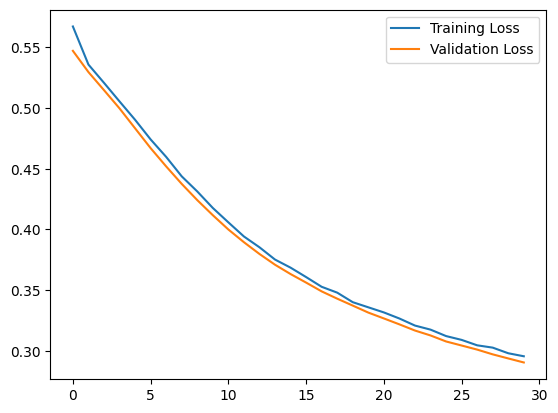

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.8718
변경 후 F1 Score: 0.8708


### 모델링 수정 - 배치사이즈 조정(증가)

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.3701 - loss: 0.7329 - val_accuracy: 0.6307 - val_loss: 0.6675
Epoch 2/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6729 - loss: 0.6521 - val_accuracy: 0.7080 - val_loss: 0.6096
Epoch 3/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7060 - loss: 0.6004 - val_accuracy: 0.7067 - val_loss: 0.5771
Epoch 4/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 0.5721 - val_accuracy: 0.7066 - val_loss: 0.5614
Epoch 5/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 0.5585 - val_accuracy: 0.7066 - val_loss: 0.5538
Epoch 6/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7045 - loss: 0.5512 - val_accuracy: 0.7066 - val_loss: 0.5478
Epoch 7/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7045 - loss: 0.5448 - val_accuracy: 0.7066 - val_loss: 0.5417
Epoch 8/30
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7046 - loss: 0.5381 - val_accuracy: 0.6878 - val_loss: 0.5358
Epoch 9/30
4

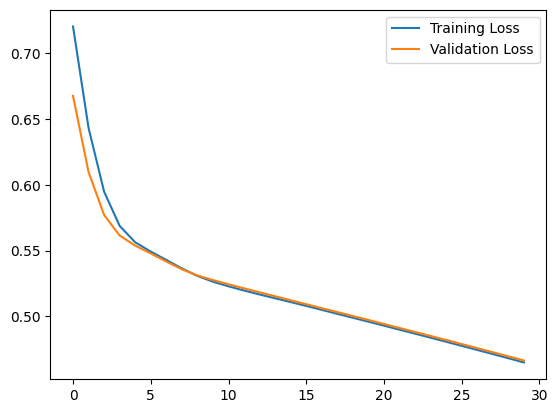

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.7685
변경 후 F1 Score: 0.7574


### 모델링 수정 - 배치사이즈 조정(감소)

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6049 - loss: 0.6311 - val_accuracy: 0.7304 - val_loss: 0.5305
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7350 - loss: 0.5224 - val_accuracy: 0.7471 - val_loss: 0.5034
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7534 - loss: 0.4955 - val_accuracy: 0.7468 - val_loss: 0.4764
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7613 - loss: 0.4678 - val_accuracy: 0.7613 - val_loss: 0.4495
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7698 - loss: 0.4412 - val_accuracy: 0.7788 - val_loss: 0.4259
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7834 - loss: 0.4180 - val_accuracy: 0.7961 - val_loss: 0.4056
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.3978 - val_accuracy: 0.8094 - val_loss: 0.3883
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.3807 - val_accuracy: 0.8165 - val_loss: 0.3735
Epo

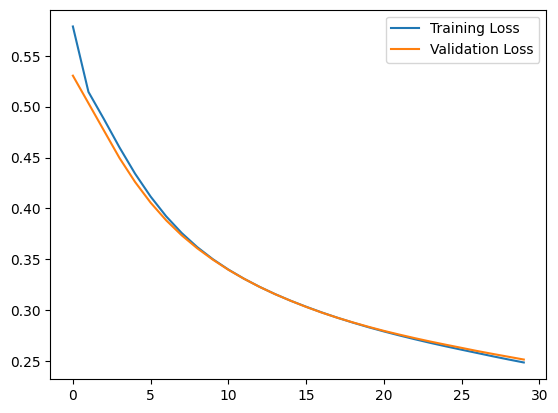

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 596us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.8847
변경 후 F1 Score: 0.8840


### 모델링 수정 - 클래스 불균형 보완

#### 클래스 불균형 문제 해결(SMOTE)
- SMOTE(Synthetic Minority Over-sampling Technique)는 불균형 데이터셋에서 소수 클래스의 데이터를 증가시켜 데이터 균형을 맞추는 오버샘플링 기법입니다.

    |<b>SMOTE 작동방식</b> |
    | :--: |
    | ![](https://miro.medium.com/v2/resize:fit:720/format:webp/1*CeOd_Wbn7O6kpjSTKTIUog.png)|
    | 출처:https://medium.com/@parthdholakiya180/smote-synthetic-minority-over-sampling-technique-4d5a5d69d720|


[[    0  5641]
 [    1 13587]]


1.0    13587
0.0    13587
Name: count, dtype: int64

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6462 - loss: 0.6427 - val_accuracy: 0.7429 - val_loss: 0.5793
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7223 - loss: 0.5587 - val_accuracy: 0.7719 - val_loss: 0.5295
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7724 - loss: 0.5103 - val_accuracy: 0.7828 - val_loss: 0.4884
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7986 - loss: 0.4676 - val_accuracy: 0.7958 - val_loss: 0.4591
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8185 - loss: 0.4319 - val_accuracy: 0.8125 - val_loss: 0.4358
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8339 - loss: 0.4028 - val_accuracy: 0.8304 - val_loss: 0.4174
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8478 - loss: 0.3798 - val_accuracy: 0.8440 - val_loss: 0.4017
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8600 - loss: 0.3616 - val_accuracy: 0.8502 - val_loss: 0.3889
Epo

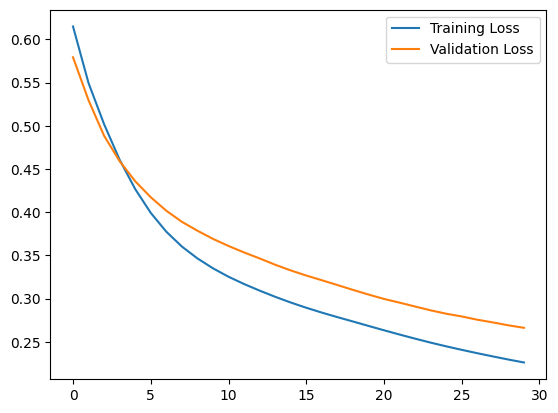

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 595us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.9019
변경 후 F1 Score: 0.9046


### 최종 모델링

Epoch 1/30


C:\Users\Han\Miniconda3\envs\hyundai_equip_6\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6996 - loss: 0.5880 - val_accuracy: 0.8179 - val_loss: 0.4126
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8542 - loss: 0.3779 - val_accuracy: 0.8800 - val_loss: 0.3344
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8817 - loss: 0.3108 - val_accuracy: 0.8860 - val_loss: 0.2972
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9013 - loss: 0.2633 - val_accuracy: 0.8924 - val_loss: 0.2438
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9120 - loss: 0.2298 - val_accuracy: 0.9086 - val_loss: 0.2193
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9221 - loss: 0.2028 - val_accuracy: 0.9051 - val_loss: 0.2128
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9286 - loss: 0.1811 - val_accuracy: 0.9120 - val_loss: 0.2031
Epoch 8/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9315 - loss: 0.1699 - val_accuracy: 0.9176 - val_loss: 0.1846
Epo

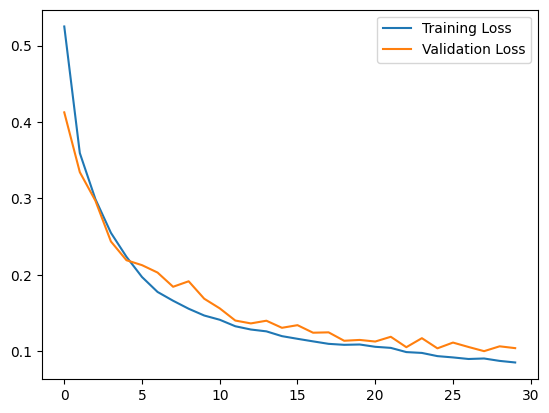

201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step
초기 모델 Accuracy: 0.8624
초기 모델 F1 Score: 0.8613
변경 후 Accuracy: 0.9633
변경 후 F1 Score: 0.9637
